In [1]:
EPISODE = 9
CAMERAS = ["top", "front", "side-1", "side-2"]
cameras = [camera.replace("-", "_") for camera in CAMERAS]

In [2]:
from arm.utils import stack_on_channel
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in cameras:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])
        
        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds

def _obj_to_dict(obj):
    return {k: v for k, v in obj.items() if not k.startswith('_')}

def _dict_to_tensor(d):
    for k, v in d.items():
        if isinstance(v, np.ndarray):
            d[k] = torch.from_numpy(v[np.newaxis, np.newaxis, ...]).to(device)
        else:
            pass
    return d

def _obj_to_tensor(obj):
    return _dict_to_tensor(_obj_to_dict(obj))

/home/khiem/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(-0.5, 1919.5, 1079.5, -0.5)

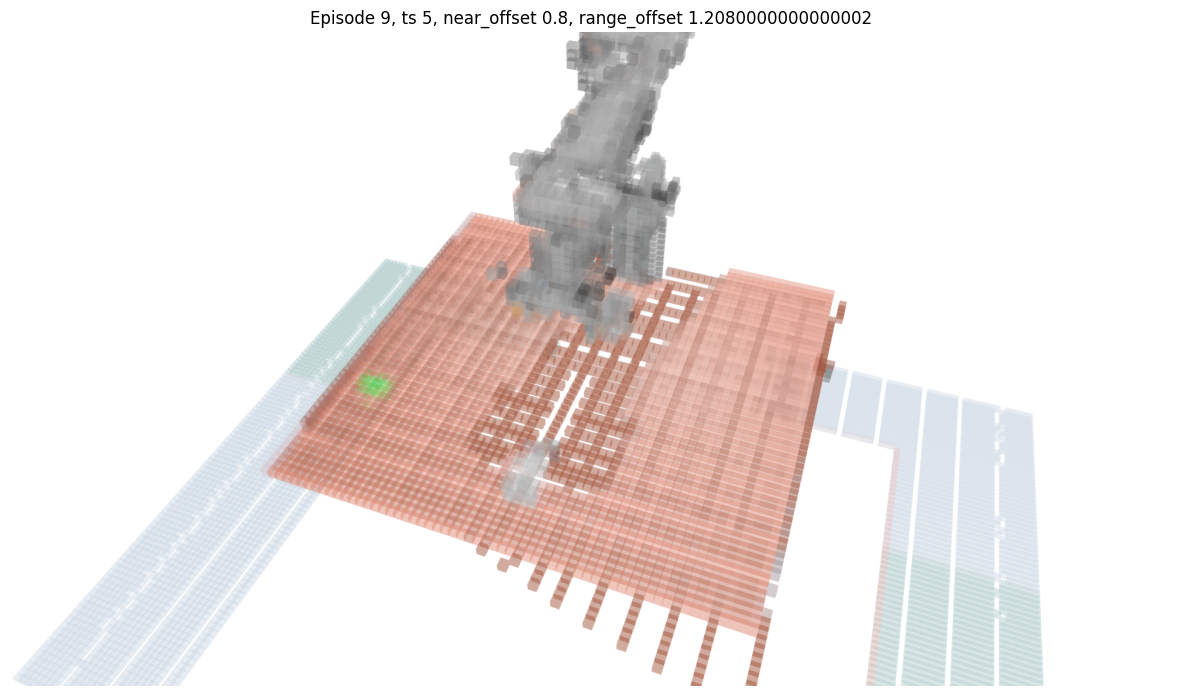

In [3]:
from rlbench.backend.utils import extract_obs
from rlbench.utils import get_stored_demo_load
import matplotlib.pyplot as plt
from arm.utils import visualise_voxel
from components.voxel_grid import VoxelGrid

IMAGE_SIZE = 128

ts = 5
data_path = 'data'

NEAR_START = 0.8
NEAR_SPEAD = 0.02
RANGE_START = 1.1
RANGE_SPEAD = 0.02
APHA = 1.51

near_offset = NEAR_START
range_offset = near_offset*APHA
demo = get_stored_demo_load(data_path=data_path,
                            index=EPISODE,
                            near_offset=near_offset,
                            range_offset=range_offset)

SCENE_BOUNDS = [-0.5, -1, -1.8, 2, 1, 1.8]
VOXEL_SIZES = [200]
BATCH_SIZE = 1

# preprocess observations
batch = _obj_to_tensor(extract_obs(demo[ts], cameras))
obs, pcds = _preprocess_inputs(batch)

# flatten observations
bs = obs[0][0].shape[0]
pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)

image_features = [o[0] for o in obs]
feat_size = image_features[0].shape[1]
flat_imag_features = torch.cat(
    [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)

# tensorize scene bounds
bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# initialize voxelizer
vox_grid = VoxelGrid(
    coord_bounds=SCENE_BOUNDS,
    voxel_size=VOXEL_SIZES[0],
    device=device,
    batch_size=BATCH_SIZE,
    feature_size=3,
    max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(cameras),
)

# voxelize!
voxel_grid = vox_grid.coords_to_bounding_voxel_grid(pcd_flat, 
                                                    coord_features=flat_imag_features, 
                                                    coord_bounds=bounds)

# swap to channels fist
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()

rotation_amount = 20
rendered_img = visualise_voxel(vis_voxel_grid[0],
                            None,
                            None,
                            None,
                            voxel_size=0.045,
                            rotation_amount=np.deg2rad(rotation_amount))
fig = plt.figure(figsize=(15, 15))
plt.title(f"Episode {EPISODE}, ts {ts}, near_offset {near_offset}, range_offset {range_offset}")
plt.imshow(rendered_img)
plt.axis('off')

In [4]:
from PIL import Image

frames = []
for i in range(36):
  rotation_amount = i * 10
  rendered_img = visualise_voxel(vis_voxel_grid[0],
                                None,
                                None,
                                None,
                                voxel_size=0.045,
                                rotation_amount=np.deg2rad(rotation_amount))
  rendered_img = Image.fromarray(rendered_img)
  frames.append(rendered_img)

frames[0].save('voxel.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)
